#### Import Modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

#### Load and Transform Data

In [ ]:
# transforms
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)) # <- normalisation values for svhn images
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

In [ ]:
# load SVHN
train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


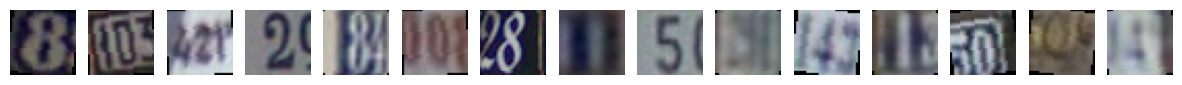

In [ ]:
# data visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

## undo normalisation
images = images * 0.5 + 0.5

fig, axes = plt.subplots(1, 15, figsize=(15, 5))
for i in range(15):
    axes[i].imshow(images[i].permute(1, 2, 0).numpy())
    axes[i].axis('off')
plt.show()

#### CNN Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, activation=nn.ReLU(), sparsity=False):
        super(Autoencoder, self).__init__()
        self.sparsity = sparsity
        self.activation = activation

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), #(16,16,16)
            nn.BatchNorm2d(16),
            self.activation,

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), #(8,8,32)
            nn.BatchNorm2d(32),
            self.activation,

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), #(4,4,64)
            nn.BatchNorm2d(64),
            self.activation,

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), #(8,8,32)
            nn.BatchNorm2d(32),
            self.activation,

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), #(16,16,16)
            nn.BatchNorm2d(16),
            self.activation,

            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1), #(32,32,3)
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# weight clipping
def clip_weights(model):
    for param in model.parameters():
        param.data.clamp_(-0.5, 0.5)

In [ ]:
# get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Training, Validation and Testing Function

In [ ]:
# training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=100):
    model.train()
    train_losses, val_losses = [], []
    prev_val_loss = float('inf')
    for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            # load data to device
            images = images.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, images)

            if model.sparsity:
                l1_reg = sum(param.abs().sum() for param in model.parameters())
                loss += 1e-5 * l1_reg

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            clip_weights(model)

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # validation Loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, images).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # stop if loss curve stabilizes
        if abs(prev_val_loss - val_loss) < 1e-4:
            print("Loss curve stabilized. Stopping training.")
            break

        prev_val_loss = val_loss

    # train vs val loss
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

In [ ]:
def test_model(model, test_loader):
    model.eval()
    psnr_total = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)

            psnr_total += psnr(images.cpu().numpy(), outputs.cpu().numpy(), data_range=1.0)

    return psnr_total / len(test_loader)

In [ ]:
# helper function to plot reconstructed images
def plot_sample_predictions(model, test_loader):
    model.eval()
    images, _ = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)

    images = (images + 1) / 2
    outputs = (outputs + 1) / 2

    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    for i in range(5):
        axes[0, i].imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        axes[1, i].imshow(np.transpose(outputs[i].cpu().detach().numpy(), (1, 2, 0)))
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")
    plt.show()

#### Implementation

###### Model 1 : without sparsity

In [ ]:
sparsity = False

In [ ]:
# init model, loss and optimiser
model = Autoencoder(sparsity=sparsity).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

Epoch [1/100], Train Loss: 0.0323, Val Loss: 0.0099
Epoch [2/100], Train Loss: 0.0069, Val Loss: 0.0055
Epoch [3/100], Train Loss: 0.0048, Val Loss: 0.0042
Epoch [4/100], Train Loss: 0.0038, Val Loss: 0.0035
Epoch [5/100], Train Loss: 0.0032, Val Loss: 0.0029
Epoch [6/100], Train Loss: 0.0029, Val Loss: 0.0025
Epoch [7/100], Train Loss: 0.0025, Val Loss: 0.0024
Epoch [8/100], Train Loss: 0.0024, Val Loss: 0.0021
Epoch [9/100], Train Loss: 0.0022, Val Loss: 0.0020
Epoch [10/100], Train Loss: 0.0021, Val Loss: 0.0022
Epoch [11/100], Train Loss: 0.0020, Val Loss: 0.0019
Epoch [12/100], Train Loss: 0.0019, Val Loss: 0.0019
Loss curve stabilized. Stopping training.


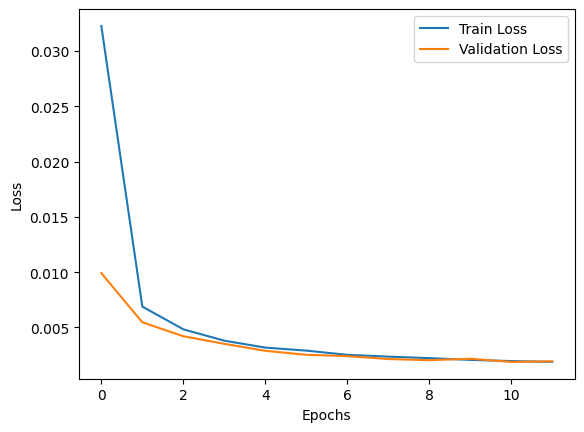

In [ ]:
# train and save model
model = train_model(model, train_loader, val_loader, optimizer, criterion)
torch.save(model.state_dict(), f"model_{'sparse' if sparsity else 'regular'}_{nn.ReLU().__class__.__name__}_{optim.Adam.__name__}.pth")

In [ ]:
#evaluate model performance
psnr_score = test_model(model, test_loader)
print("psnr score = ", psnr_score)

psnr score =  27.349839705500294


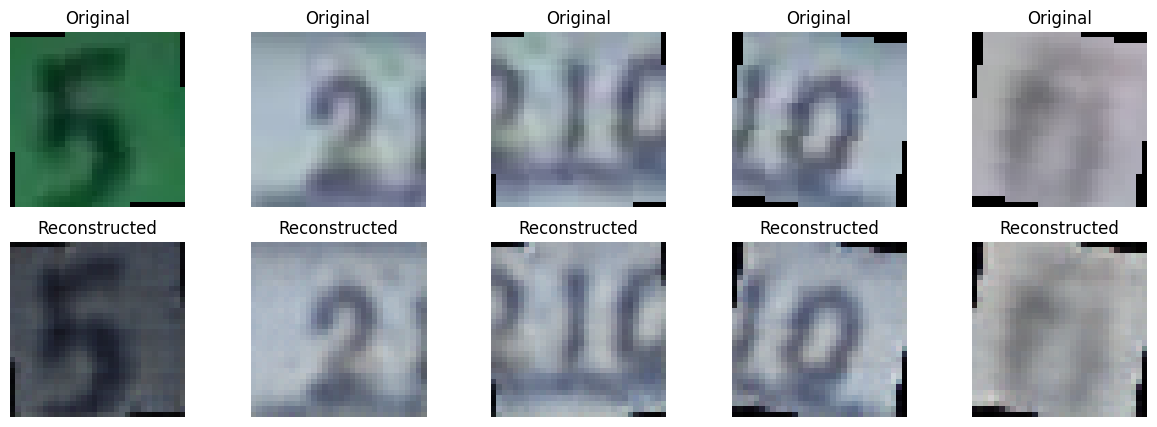

In [ ]:
plot_sample_predictions(model, test_loader)

###### Model 2 : with sparsity

In [ ]:
sparsity = True

In [ ]:
# init model, loss and optimiser
model = Autoencoder(sparsity=sparsity).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

Epoch [1/100], Train Loss: 0.0393, Val Loss: 0.0090
Epoch [2/100], Train Loss: 0.0120, Val Loss: 0.0049
Epoch [3/100], Train Loss: 0.0091, Val Loss: 0.0040
Epoch [4/100], Train Loss: 0.0082, Val Loss: 0.0036
Epoch [5/100], Train Loss: 0.0075, Val Loss: 0.0030
Epoch [6/100], Train Loss: 0.0069, Val Loss: 0.0033
Epoch [7/100], Train Loss: 0.0066, Val Loss: 0.0027
Epoch [8/100], Train Loss: 0.0063, Val Loss: 0.0027
Loss curve stabilized. Stopping training.


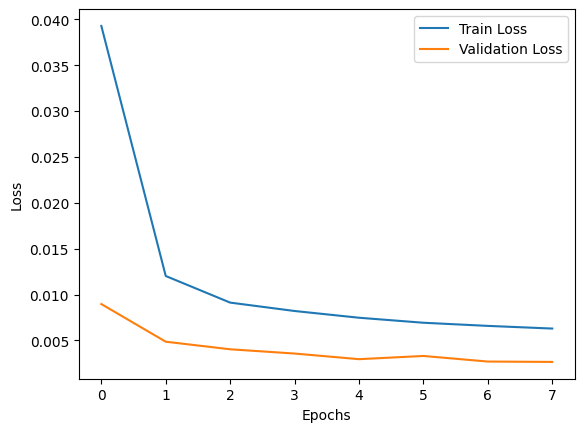

In [ ]:
# train and save model
model = train_model(model, train_loader, val_loader, optimizer, criterion)
torch.save(model.state_dict(), f"model_{'sparse' if sparsity else 'regular'}_{nn.ReLU().__class__.__name__}_{optim.Adam.__name__}.pth")

In [ ]:
#evaluate model performance
psnr_score = test_model(model, test_loader)
print("psnr score = ", psnr_score)

psnr score =  25.86983013367798


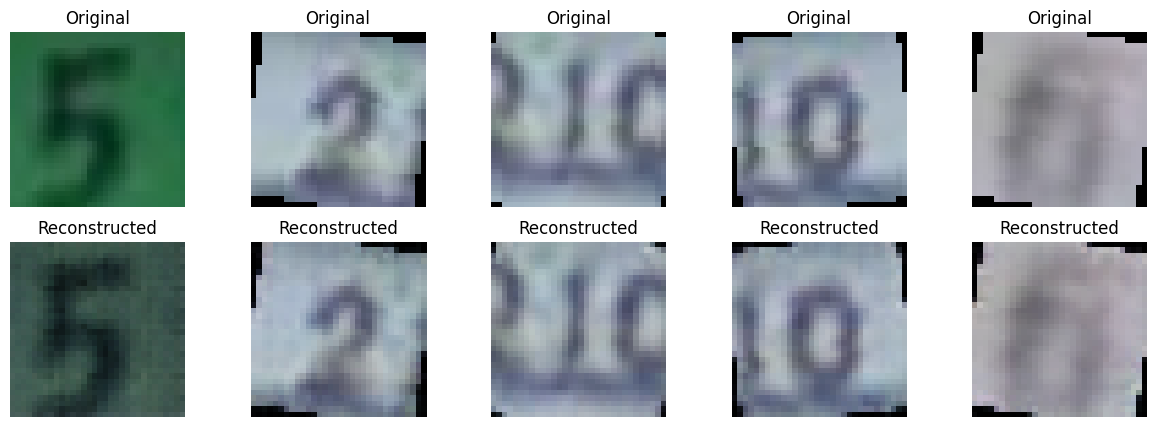

In [ ]:
plot_sample_predictions(model, test_loader)

sparsity involves enforcing that only a small number of neurons are active at any given time in the latent space. by forcing only a small subset of neurons to be active, the autoencoder has fewer "features" to represent each input image and hence hurting the performance

the results amplify this point with higher psnr score for the model with no sparsity (l1 reg)

#### Hyperparameter Tuning

In [ ]:
# hyperparameters
activations = [nn.ReLU(), nn.LeakyReLU()]
optimizers = [optim.Adam, optim.SGD]

Epoch [1/100], Train Loss: 0.0301, Val Loss: 0.0103
Epoch [2/100], Train Loss: 0.0064, Val Loss: 0.0051
Epoch [3/100], Train Loss: 0.0045, Val Loss: 0.0038
Epoch [4/100], Train Loss: 0.0035, Val Loss: 0.0031
Epoch [5/100], Train Loss: 0.0030, Val Loss: 0.0028
Epoch [6/100], Train Loss: 0.0026, Val Loss: 0.0024
Epoch [7/100], Train Loss: 0.0023, Val Loss: 0.0021
Epoch [8/100], Train Loss: 0.0022, Val Loss: 0.0020
Epoch [9/100], Train Loss: 0.0020, Val Loss: 0.0018
Epoch [10/100], Train Loss: 0.0019, Val Loss: 0.0017
Loss curve stabilized. Stopping training.


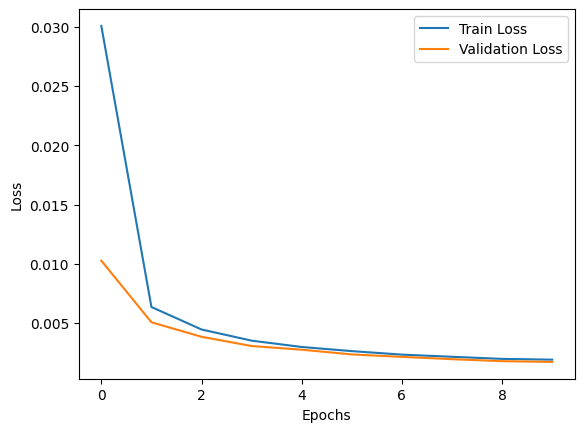

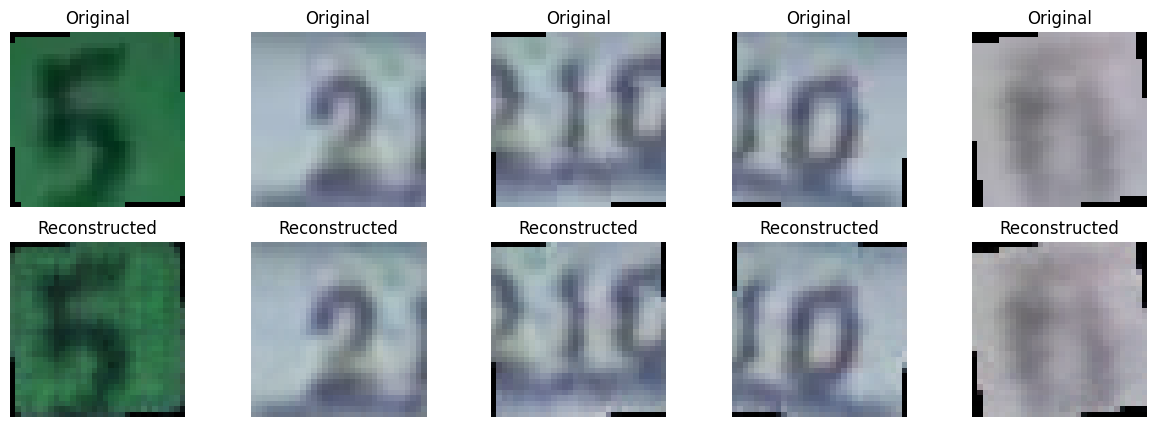

Epoch [1/100], Train Loss: 0.0470, Val Loss: 0.0114
Epoch [2/100], Train Loss: 0.0132, Val Loss: 0.0050
Epoch [3/100], Train Loss: 0.0097, Val Loss: 0.0048
Epoch [4/100], Train Loss: 0.0084, Val Loss: 0.0035
Epoch [5/100], Train Loss: 0.0076, Val Loss: 0.0031
Epoch [6/100], Train Loss: 0.0073, Val Loss: 0.0029
Epoch [7/100], Train Loss: 0.0068, Val Loss: 0.0029
Loss curve stabilized. Stopping training.


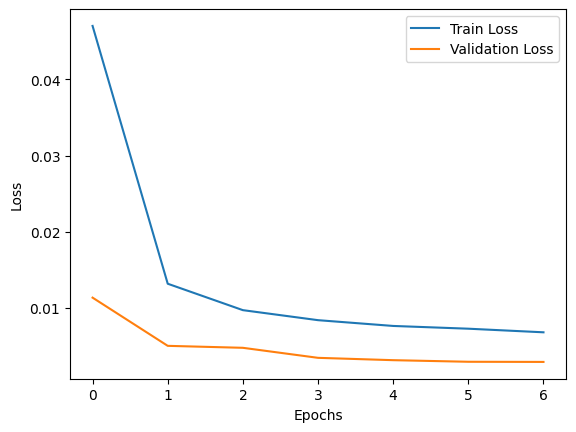

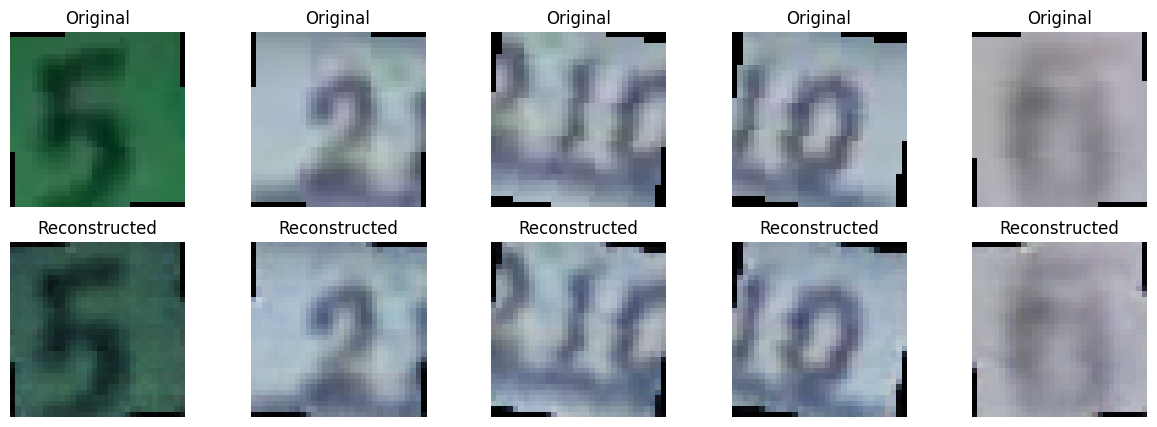

Epoch [1/100], Train Loss: 0.2385, Val Loss: 0.2268
Epoch [2/100], Train Loss: 0.2065, Val Loss: 0.1959
Epoch [3/100], Train Loss: 0.1913, Val Loss: 0.1873
Epoch [4/100], Train Loss: 0.1842, Val Loss: 0.1812
Epoch [5/100], Train Loss: 0.1789, Val Loss: 0.1762
Epoch [6/100], Train Loss: 0.1737, Val Loss: 0.1710
Epoch [7/100], Train Loss: 0.1679, Val Loss: 0.1648
Epoch [8/100], Train Loss: 0.1610, Val Loss: 0.1574
Epoch [9/100], Train Loss: 0.1534, Val Loss: 0.1496
Epoch [10/100], Train Loss: 0.1457, Val Loss: 0.1425
Epoch [11/100], Train Loss: 0.1389, Val Loss: 0.1360
Epoch [12/100], Train Loss: 0.1331, Val Loss: 0.1307
Epoch [13/100], Train Loss: 0.1280, Val Loss: 0.1261
Epoch [14/100], Train Loss: 0.1238, Val Loss: 0.1219
Epoch [15/100], Train Loss: 0.1198, Val Loss: 0.1182
Epoch [16/100], Train Loss: 0.1163, Val Loss: 0.1149
Epoch [17/100], Train Loss: 0.1131, Val Loss: 0.1119
Epoch [18/100], Train Loss: 0.1102, Val Loss: 0.1088
Epoch [19/100], Train Loss: 0.1073, Val Loss: 0.1062
Ep

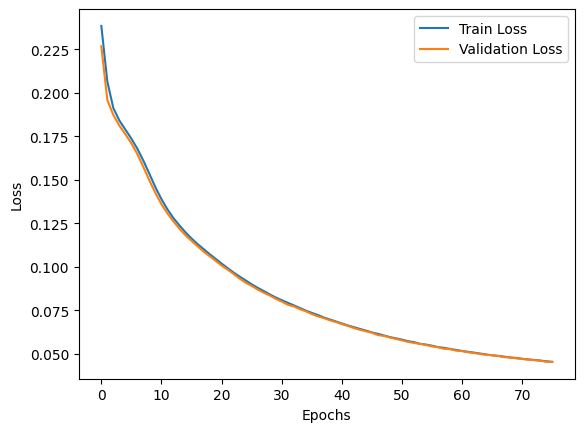

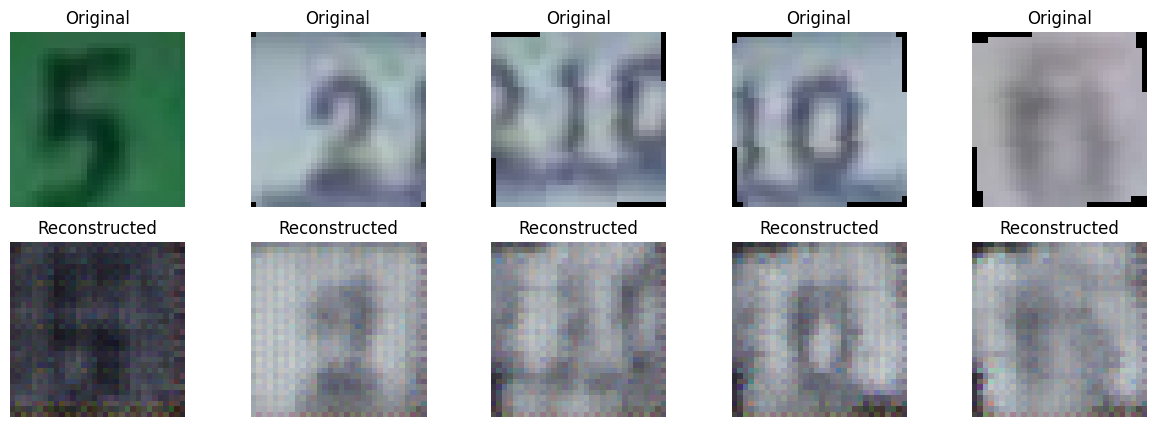

Epoch [1/100], Train Loss: 0.2793, Val Loss: 0.2422
Epoch [2/100], Train Loss: 0.2337, Val Loss: 0.2020
Epoch [3/100], Train Loss: 0.2105, Val Loss: 0.1870
Epoch [4/100], Train Loss: 0.1980, Val Loss: 0.1764
Epoch [5/100], Train Loss: 0.1873, Val Loss: 0.1654
Epoch [6/100], Train Loss: 0.1760, Val Loss: 0.1541
Epoch [7/100], Train Loss: 0.1646, Val Loss: 0.1429
Epoch [8/100], Train Loss: 0.1536, Val Loss: 0.1322
Epoch [9/100], Train Loss: 0.1436, Val Loss: 0.1227
Epoch [10/100], Train Loss: 0.1343, Val Loss: 0.1141
Epoch [11/100], Train Loss: 0.1266, Val Loss: 0.1069
Epoch [12/100], Train Loss: 0.1199, Val Loss: 0.1010
Epoch [13/100], Train Loss: 0.1146, Val Loss: 0.0962
Epoch [14/100], Train Loss: 0.1100, Val Loss: 0.0919
Epoch [15/100], Train Loss: 0.1062, Val Loss: 0.0882
Epoch [16/100], Train Loss: 0.1028, Val Loss: 0.0851
Epoch [17/100], Train Loss: 0.0998, Val Loss: 0.0823
Epoch [18/100], Train Loss: 0.0973, Val Loss: 0.0798
Epoch [19/100], Train Loss: 0.0948, Val Loss: 0.0775
Ep

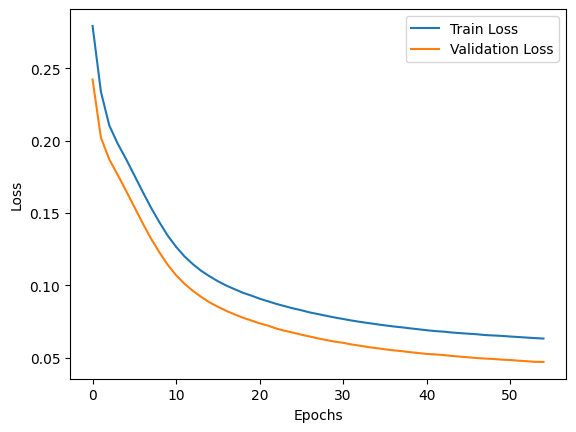

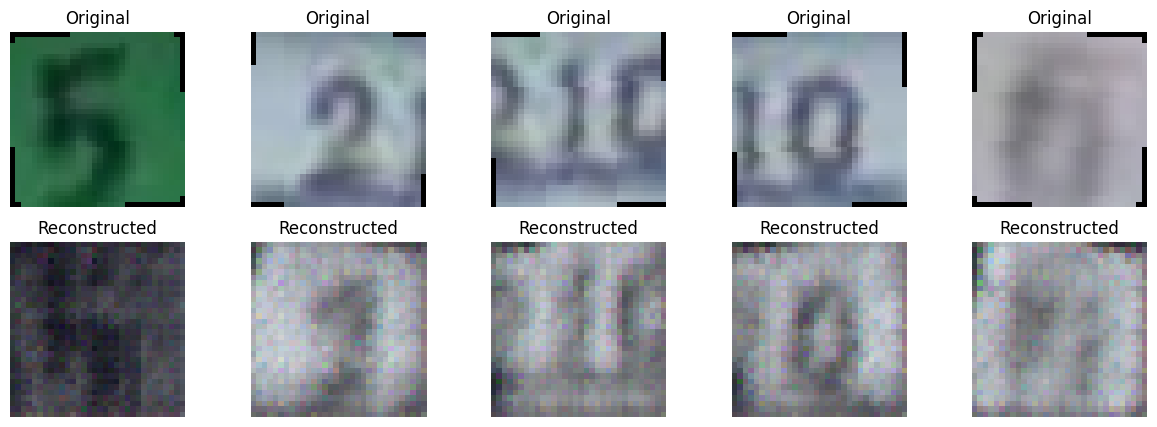

Epoch [1/100], Train Loss: 0.0297, Val Loss: 0.0092
Epoch [2/100], Train Loss: 0.0066, Val Loss: 0.0055
Epoch [3/100], Train Loss: 0.0046, Val Loss: 0.0040
Epoch [4/100], Train Loss: 0.0037, Val Loss: 0.0034
Epoch [5/100], Train Loss: 0.0031, Val Loss: 0.0028
Epoch [6/100], Train Loss: 0.0027, Val Loss: 0.0027
Epoch [7/100], Train Loss: 0.0025, Val Loss: 0.0024
Epoch [8/100], Train Loss: 0.0023, Val Loss: 0.0022
Epoch [9/100], Train Loss: 0.0021, Val Loss: 0.0019
Epoch [10/100], Train Loss: 0.0020, Val Loss: 0.0018
Epoch [11/100], Train Loss: 0.0019, Val Loss: 0.0017
Epoch [12/100], Train Loss: 0.0017, Val Loss: 0.0016
Loss curve stabilized. Stopping training.


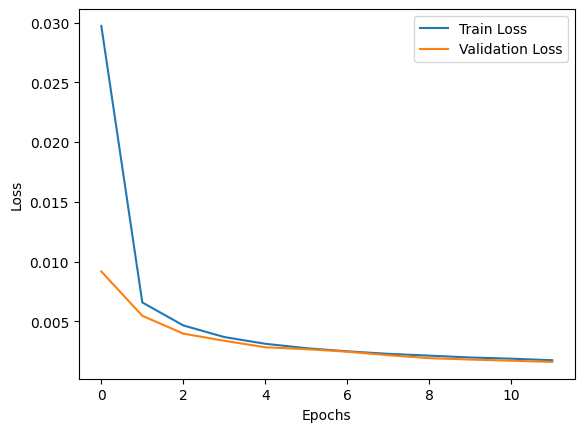

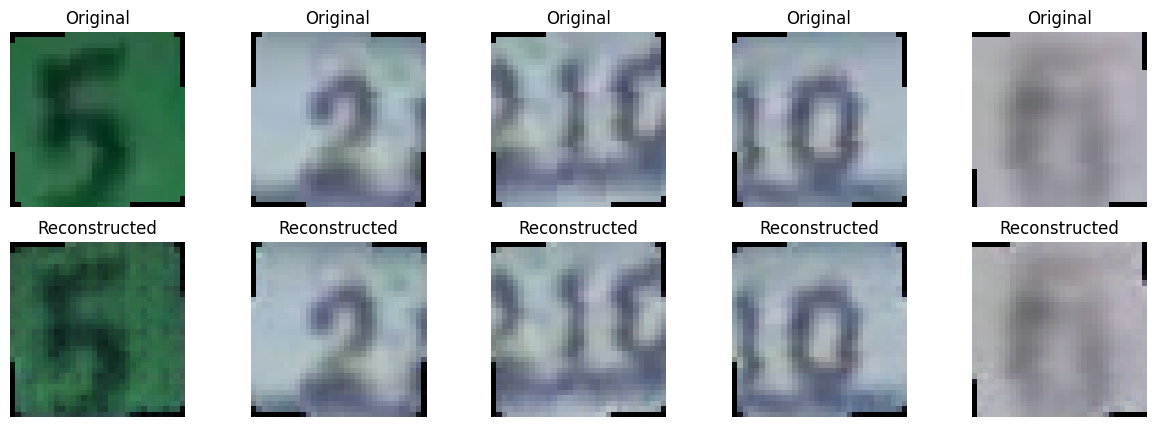

Epoch [1/100], Train Loss: 0.0447, Val Loss: 0.0088
Epoch [2/100], Train Loss: 0.0139, Val Loss: 0.0059
Epoch [3/100], Train Loss: 0.0097, Val Loss: 0.0045
Epoch [4/100], Train Loss: 0.0085, Val Loss: 0.0038
Epoch [5/100], Train Loss: 0.0077, Val Loss: 0.0043
Epoch [6/100], Train Loss: 0.0072, Val Loss: 0.0032
Epoch [7/100], Train Loss: 0.0068, Val Loss: 0.0027
Epoch [8/100], Train Loss: 0.0063, Val Loss: 0.0024
Epoch [9/100], Train Loss: 0.0061, Val Loss: 0.0024
Loss curve stabilized. Stopping training.


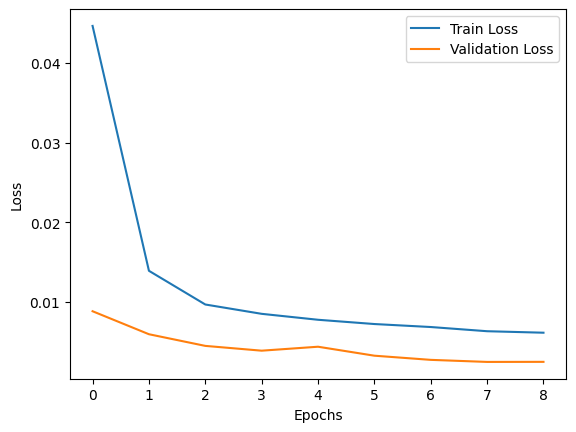

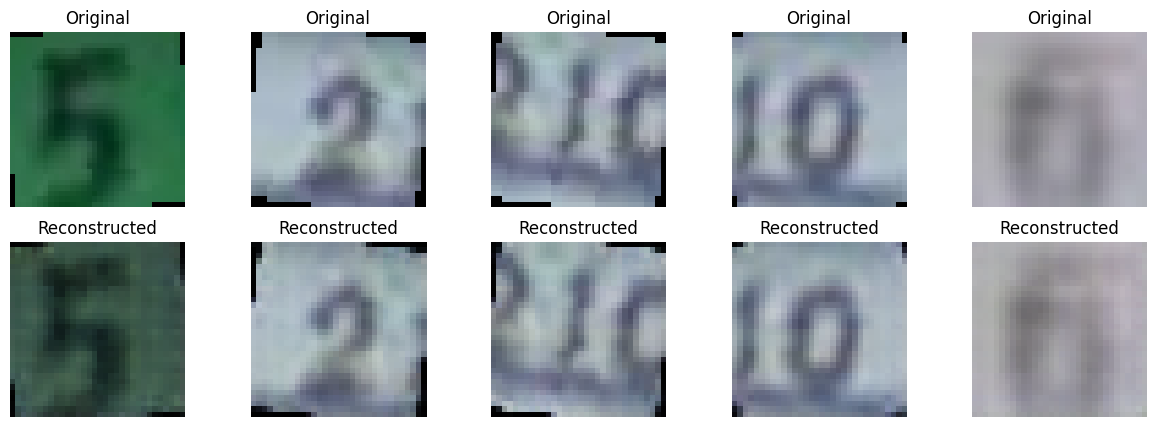

Epoch [1/100], Train Loss: 0.2400, Val Loss: 0.2251
Epoch [2/100], Train Loss: 0.2037, Val Loss: 0.1920
Epoch [3/100], Train Loss: 0.1868, Val Loss: 0.1824
Epoch [4/100], Train Loss: 0.1786, Val Loss: 0.1747
Epoch [5/100], Train Loss: 0.1702, Val Loss: 0.1657
Epoch [6/100], Train Loss: 0.1608, Val Loss: 0.1562
Epoch [7/100], Train Loss: 0.1507, Val Loss: 0.1456
Epoch [8/100], Train Loss: 0.1401, Val Loss: 0.1348
Epoch [9/100], Train Loss: 0.1301, Val Loss: 0.1256
Epoch [10/100], Train Loss: 0.1214, Val Loss: 0.1176
Epoch [11/100], Train Loss: 0.1138, Val Loss: 0.1106
Epoch [12/100], Train Loss: 0.1078, Val Loss: 0.1050
Epoch [13/100], Train Loss: 0.1024, Val Loss: 0.1000
Epoch [14/100], Train Loss: 0.0978, Val Loss: 0.0959
Epoch [15/100], Train Loss: 0.0937, Val Loss: 0.0919
Epoch [16/100], Train Loss: 0.0901, Val Loss: 0.0885
Epoch [17/100], Train Loss: 0.0866, Val Loss: 0.0852
Epoch [18/100], Train Loss: 0.0835, Val Loss: 0.0824
Epoch [19/100], Train Loss: 0.0807, Val Loss: 0.0795
Ep

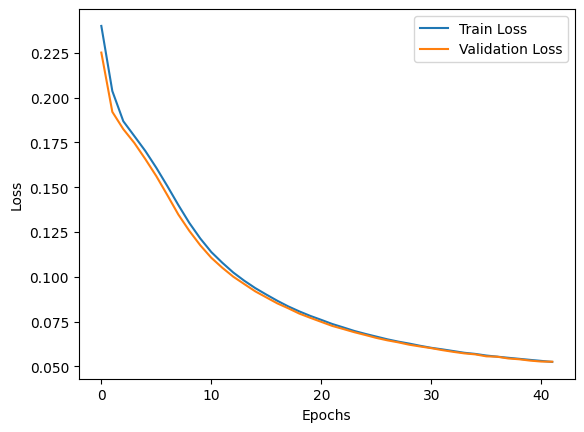

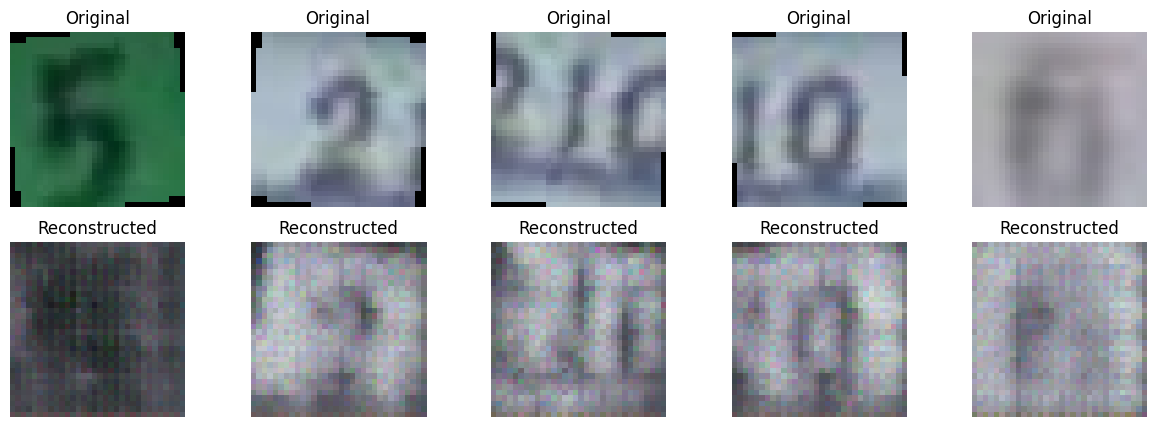

Epoch [1/100], Train Loss: 0.2584, Val Loss: 0.2286
Epoch [2/100], Train Loss: 0.2195, Val Loss: 0.1912
Epoch [3/100], Train Loss: 0.2032, Val Loss: 0.1834
Epoch [4/100], Train Loss: 0.1971, Val Loss: 0.1780
Epoch [5/100], Train Loss: 0.1915, Val Loss: 0.1725
Epoch [6/100], Train Loss: 0.1848, Val Loss: 0.1643
Epoch [7/100], Train Loss: 0.1754, Val Loss: 0.1538
Epoch [8/100], Train Loss: 0.1642, Val Loss: 0.1419
Epoch [9/100], Train Loss: 0.1527, Val Loss: 0.1310
Epoch [10/100], Train Loss: 0.1427, Val Loss: 0.1218
Epoch [11/100], Train Loss: 0.1347, Val Loss: 0.1150
Epoch [12/100], Train Loss: 0.1286, Val Loss: 0.1097
Epoch [13/100], Train Loss: 0.1236, Val Loss: 0.1050
Epoch [14/100], Train Loss: 0.1193, Val Loss: 0.1011
Epoch [15/100], Train Loss: 0.1155, Val Loss: 0.0974
Epoch [16/100], Train Loss: 0.1122, Val Loss: 0.0942
Epoch [17/100], Train Loss: 0.1090, Val Loss: 0.0911
Epoch [18/100], Train Loss: 0.1059, Val Loss: 0.0882
Epoch [19/100], Train Loss: 0.1032, Val Loss: 0.0857
Ep

KeyboardInterrupt: 

In [ ]:
results = {}
for act in activations:
    for opt in optimizers:
        for sparsity in [False, True]:
            model = Autoencoder(activation=act, sparsity=sparsity).to(device)
            optimizer = opt(model.parameters(), lr=0.001)
            criterion = nn.MSELoss()

            # train
            model = train_model(model, train_loader, val_loader, optimizer, criterion)
            torch.save(model.state_dict(), f"model_{'sparse' if sparsity else 'regular'}_{act.__class__.__name__}_{opt.__name__}.pth")

            # test performance
            psnr_score = test_model(model, test_loader)

            # results
            key = f"Activation: {act.__class__.__name__}, Optimizer: {opt.__name__}, Sparsity: {sparsity}"
            results[key] = {"PSNR": psnr_score}

            # plotting predictions
            plot_sample_predictions(model, test_loader)

In [ ]:
for config, metrics in results.items():
    print(f"{config} - PSNR: {metrics['PSNR']:.2f}")

Activation: ReLU, Optimizer: Adam, Sparsity: False - PSNR: 27.93
Activation: ReLU, Optimizer: Adam, Sparsity: True - PSNR: 25.43
Activation: ReLU, Optimizer: SGD, Sparsity: False - PSNR: 13.25
Activation: ReLU, Optimizer: SGD, Sparsity: True - PSNR: 13.16
Activation: LeakyReLU, Optimizer: Adam, Sparsity: False - PSNR: 28.33
Activation: LeakyReLU, Optimizer: Adam, Sparsity: True - PSNR: 26.24
Activation: LeakyReLU, Optimizer: SGD, Sparsity: False - PSNR: 12.59


these results suggest that  performs slightly better than ReLU based on the PSNR values (28.33 vs 27.93), indicating that the model with LeakyReLU might preserve more important features or reduce information loss during reconstruction.


the Adam Optimizer consistently outperforms Stochastic Gradient Descent and also takes much lesser time to converge (as can be seen in training logs)

sparsity constraint / L1 regularization reduces the PSNR in all cases.

the best model would be with: Activation: LeakyReLU, Optimizer: Adam, Sparsity: False - PSNR: 28.33